# Deep learning for sequential data - Lab

**Submission deadlines:**

* Get at least 5 points by Friday 01.12.2023
* Remaining points: TBD (we will decide together on Friday)

*Points:* There are in total 26.5 points. **Aim to get 20 points (i.e. 20 points = maximum grade)**. The passing grade is 10 points. If you get more than 20 points, the extra points might be counted as bonuses towards the grade of the course.

## Submission instructions:

You have two options for submission:

1. Present in person your solutions during the session on Friday 01.12.2023, or at any point during the week from 04.12.2023 to 08.12.2023 (contact me by email in order to agree on the time. It could be by videocall depending on convenience). **You get extra 0.1 points** for every task presented this way, and no comments are required in the code.
2. Submit your solutions through moodle by TBD (we will decide together on Friday) at the latest. Detailed written explanations are required in the comments for every task.

I provide some starter code, however, you are not required to use it as long as you properly solve the tasks.

Make sure you know all the quetions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`).

**Reach out to me at santiago.cuervo@lis-lab.fr for any question or issue you might encounter.**

# Problem 1. RNNs on to the parity task

We will work on a toy problem: the parity task.

*Inputs:* a variable sized sequence of bits.

*Outputs:* a binary indicator that is `0` if the sequence contains an even number of ones and `1` otherwise.

Eg.

$x_1$: `0,0,0,1,0,1` , $y_1$: `0`

$x_2$: `0,0,0,1,0,1,1` , $y_2$: `1`

Note that this is equivalent to the RNN learning to apply a XOR function at each time step.

**Tasks**:

1. **(1 pt)** Implement the vanilla RNN in PyTorch. A vanilla RNN is described by the following recurrence:

    $H_t = \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h)$

    Where $X_t$ are the inputs, $H_t$ are the states, $W_{xh}$ and $W_{hh}$ are weight matrices connecting the state to the inputs and the previous state, respectively, and $b_{h}$ is the bias term.

2. **(2 pt max.)** Use your RNN implementation to solve the parity task. For this:
    
    * (0.5 pt) Implement the call to the forward pass of the RNN in order to compute the sequence of hidden states.
    * (0.5 pt) Apply a simple MSE loss to train the network. Implement two training modes in which: 1) The loss is applied at each time-step and 2) The loss is applied only at the last timestep. There is a boolean flag in the code called `full_supervision` that controls this behavior.
    * (1 pt) Here you don't have to implement any extra code. Play with the values of `full_supervision`, `max_grad_norm` and `seq_len` and analyze how it affects the training dynamics.

3. **(1 pt)** Implement the LSTM cell according to the equations from the slides and apply it to the parity task. Do you notice any change in the training dynamics?

3. **(0.5 pt)** In the setup without full supervision, try to train both the vanilla RNN and the LSTM in long sequences. Is there any advantage in using the LSTM?

In [3]:
%matplotlib inline

In [4]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm


In [5]:
# We'll be using very small networks, so things might go slower on a GPU. Change it to True if you want to try with GPU or things go slow
CUDA = False

In [6]:
def np_to_tensor(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: in this code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [7]:
class SimpleRNNCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)
        self.activation = activation
        # Input to hidden
        self.Wxh = nn.Parameter(torch.Tensor(in_dim, hidden_dim))
        # Hidden to hidden
        self.Whh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        # Hidden bias
        self.bh = nn.Parameter(torch.Tensor(hidden_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Whh.size(1))
        self.Wxh.data.uniform_(-stdv, stdv)
        self.Whh.data.uniform_(-stdv, stdv)
        self.bh.data.zero_()

    def forward(self, input, h):
        #
        # TODO TASK 1
        #
        # Compute the activation of the RNN cell (ie. the right hand side of the vanila RNN equation)

        # My task
        # Forward pass of the RNN cell.

        # Compute the pre-activation for the next hidden state.
        pre_act = torch.matmul(input, self.Wxh) + torch.matmul(h, self.Whh) + self.bh
        return self.activation(pre_act)


class RNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, input, hidden):
        cell = self.cell
        output = []
        #
        # TODO TASK 1
        #
        # Here we unroll in time and compute the recurrence
        #
        # My task
        # Compute the output for each time step in the input sequence.
        seq_len = input.shape[0]
        for i in range(seq_len):
          # Update hidden state using the RNN cell.
            hidden = cell(input[i], hidden)
            # Hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)
        # Concatenate outputs along the time dimension and reshape.
        output = torch.cat(output, 0).view(seq_len, *output[0].size())

        return hidden, output

## The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [8]:
def gen_parity_examples(time_steps, batch_size):
    X = (np.random.rand(time_steps, batch_size, 1) > 0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X, Y


Xp, Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]] 
Y.T: [[1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.]]


In [9]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

if CUDA:
    test_net.cuda()

h0 = np.zeros((1, hidden_dim), dtype='float32')  # 1 sequence in batch, 1 hidden dim
hn, out = test_net(np_to_tensor(Xp), np_to_tensor(h0)) # The network outputs a tuple of tensors: (last hidden state, hidden state at each time step)

In [10]:
class ParityNet(nn.Module):
    def __init__(self, hidden_dim, use_lstm=False, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.use_lstm = use_lstm
        if use_lstm:
            cell = LSTMCell(in_dim=1, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim, activation=nn.Sigmoid())
        self.rnn = RNN(cell)
        self.linear = nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1)

    def forward(self, inputs):
        if self.use_lstm:
            h0 = [torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device) for _ in range(2)]
        else:
            h0 = torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device)
        #
        # TODO TASK 2
        #
        # Compute the sequence of hidden states
        #
        _, H = self.rnn(inputs, h0)
        # Concatenate inputs and hidden states along the feature dimension
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return torch.sigmoid(self.linear(inputs_and_H))

Just to prove that the task is easily solvable, we will manually define the weights of our RNN to implement the XOR function:

In [11]:
parity_net = ParityNet(hidden_dim=2)

if CUDA:
    parity_net.cuda()

#
# Design the net to solve parity
#
parity_net.rnn.cell.Wxh.data[...
    ] = torch.FloatTensor([[2000, 1000]])
parity_net.rnn.cell.Whh.data[...
    ] = torch.FloatTensor([[ 1000,  1000],
                           [-1000, -1000]])
parity_net.rnn.cell.bh.data[...
    ] = torch.FloatTensor([-500, -1500])

parity_net.linear.weight.data[...
    ] = torch.FloatTensor([[ 0],
                           [ 1000],
                           [-1000]]).transpose(0, 1)
parity_net.linear.bias.data[...
    ] = torch.FloatTensor([-500])

predictions = parity_net(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
predicted:  [1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.]
        Y:  [1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.]


Now we'll try to get to the solution by learning:

In [12]:
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps
        # if full_supervision == False, supervise net outputs at the last
        # step only
        self.full_supervision = True

        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0

        self.network = network

        # RMSprop optimization stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        device = 'cuda' if CUDA else 'cpu'
        self.gnorms = [torch.zeros(*p.size(), device=device)
                       for p in self.network.parameters()]

    def train_step(self, X, Y):
        X = np_to_tensor(X)
        Y = np_to_tensor(Y)
        net = self.network
        net.zero_grad()
        # predictions
        P = net(X)
        #
        # TODO TASK 2
        #
        # Implement the loss with and without full supervision.
        # With full supervision we compute the loss at each step.
        # Without, just at the last step
        #
        if self.full_supervision:
            loss = torch.mean((P-Y)**2)  # my task
        else:
            loss = torch.mean((P[-1]-Y[-1])**2) # my task
        loss.backward()

        tot_gnorm = torch.FloatTensor((0.0,))
        if CUDA:
            tot_gnorm = tot_gnorm.cuda()
        # We apply gradient normalization to avoid exploding gradients and do the training step
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,)
                                           ).to(tot_gnorm.device), tot_gnorm)
        for i, p in enumerate(net.parameters()):
            g = p.grad.data / g_div
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())

## Exploration of various problems with RNN training

In the following cell you can experiment with various ways of providing supervision to the network: which one is easier to train - when the net recieves feedback after each step or when it recieves feedback only at the end of training? Play with gradient clipping and the curriculum as well.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship (i.e. it learns the XOR function) from which point training starts to progress very quickly.

In [13]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4):
    max_seq_len = 100
    seq_len = max_seq_len
    if learning_curriculum:
        seq_len = 10
    patience = patience_max
    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)
        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 10
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            patience = patience_max
        if i % 500 == 0:
            print(i, ret)
    losses_df = pd.DataFrame(losses)
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')

    Xp,Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

0 {'loss': 0.24889662861824036, 'grad_norm': 0.11078481376171112}
500 {'loss': 0.24296362698078156, 'grad_norm': 0.02355080470442772}
1000 {'loss': 0.2449071854352951, 'grad_norm': 0.026167478412389755}
1500 {'loss': 0.17764998972415924, 'grad_norm': 0.05938104912638664}
2000 {'loss': 0.0772659033536911, 'grad_norm': 0.041415490210056305}
2500 {'loss': 0.16942384839057922, 'grad_norm': 0.03275841847062111}
3000 {'loss': 0.00818225834518671, 'grad_norm': 0.011179717257618904}
3500 {'loss': 0.0011377854971215129, 'grad_norm': 0.0012982042971998453}
4000 {'loss': 0.0005144195165485144, 'grad_norm': 0.0008852154132910073}
4500 {'loss': 0.0003447315830271691, 'grad_norm': 0.0003314724890515208}
5000 {'loss': 0.000171397186932154, 'grad_norm': 0.00020734874124173075}
5500 {'loss': 0.000318118225550279, 'grad_norm': 0.00029821781208738685}
6000 {'loss': 0.00012835919915232807, 'grad_norm': 0.00029094191268086433}
6500 {'loss': 0.00011057256779167801, 'grad_norm': 0.00025156265473924577}
7000 

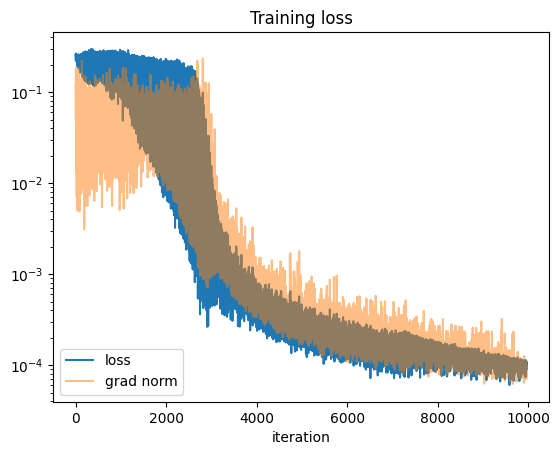

In [14]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

0 {'loss': 0.322553426027298, 'grad_norm': 0.1308766007423401}
500 {'loss': 0.23678305745124817, 'grad_norm': 0.04178516939282417}
1000 {'loss': 0.15011446177959442, 'grad_norm': 0.03397194296121597}
1500 {'loss': 0.06893537938594818, 'grad_norm': 0.03014850616455078}
2000 {'loss': 0.003779069287702441, 'grad_norm': 0.011356010101735592}
2500 {'loss': 0.16694475710391998, 'grad_norm': 0.029446961358189583}
3000 {'loss': 0.1884736716747284, 'grad_norm': 0.08688260614871979}
3500 {'loss': 0.10493872314691544, 'grad_norm': 0.07340175658464432}
4000 {'loss': 0.0006617067265324295, 'grad_norm': 0.002175520174205303}
4500 {'loss': 0.1750085949897766, 'grad_norm': 0.09036064147949219}
5000 {'loss': 0.009605847299098969, 'grad_norm': 0.007532540243119001}
5500 {'loss': 0.15791486203670502, 'grad_norm': 0.037349604070186615}
6000 {'loss': 0.09840553998947144, 'grad_norm': 0.039856791496276855}
6500 {'loss': 0.005683586932718754, 'grad_norm': 0.0050946553237736225}
7000 {'loss': 0.00022365711629

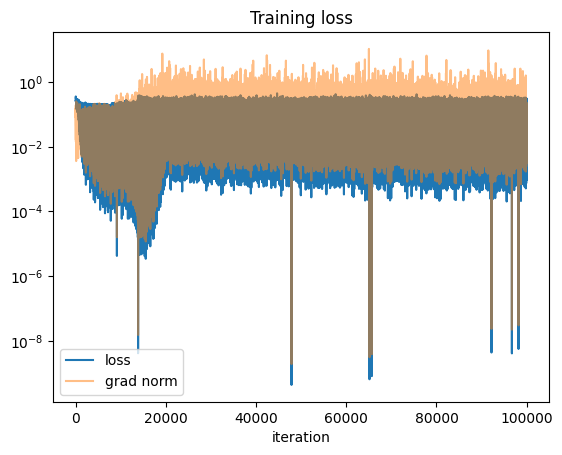

In [15]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 0.2
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

Increasing the max grad norm to 5

0 {'loss': 0.2545917332172394, 'grad_norm': 0.05218580365180969}
500 {'loss': 0.2659689784049988, 'grad_norm': 0.04535806551575661}
1000 {'loss': 0.2340136021375656, 'grad_norm': 0.0145043870434165}
1500 {'loss': 0.11919023841619492, 'grad_norm': 0.09391631186008453}
2000 {'loss': 0.22799614071846008, 'grad_norm': 0.026611147448420525}
2500 {'loss': 0.23899206519126892, 'grad_norm': 0.03234787657856941}
3000 {'loss': 0.12447245419025421, 'grad_norm': 0.08664464205503464}
3500 {'loss': 0.24948275089263916, 'grad_norm': 0.022166233509778976}
4000 {'loss': 0.18253307044506073, 'grad_norm': 0.049819935113191605}
4500 {'loss': 0.28398630023002625, 'grad_norm': 0.07230512797832489}
5000 {'loss': 0.2205696702003479, 'grad_norm': 0.056740596890449524}
5500 {'loss': 0.19731760025024414, 'grad_norm': 0.024290546774864197}
6000 {'loss': 0.23925533890724182, 'grad_norm': 0.017101306468248367}
6500 {'loss': 0.20146656036376953, 'grad_norm': 0.06294794380664825}
7000 {'loss': 0.20748290419578552, 'g

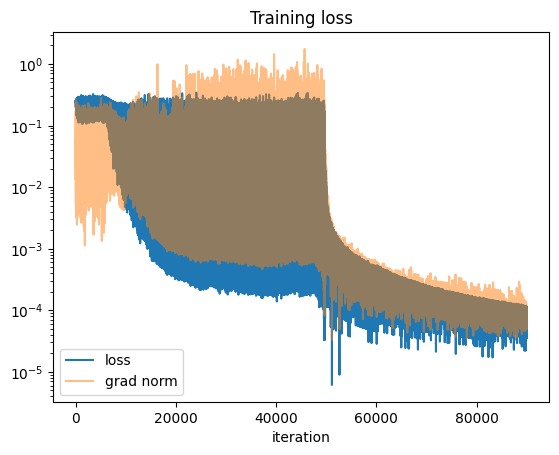

In [16]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 5.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

### Without supervision


0 {'loss': 0.2547242343425751, 'grad_norm': 0.13269034028053284}
500 {'loss': 0.22809302806854248, 'grad_norm': 0.072639599442482}
1000 {'loss': 0.2569836378097534, 'grad_norm': 0.18050721287727356}
1500 {'loss': 0.2613374888896942, 'grad_norm': 0.08353307098150253}
2000 {'loss': 0.25712117552757263, 'grad_norm': 0.0811237022280693}
2500 {'loss': 0.25780218839645386, 'grad_norm': 0.033301062881946564}
3000 {'loss': 0.2246505469083786, 'grad_norm': 0.1965578943490982}
3500 {'loss': 0.24679481983184814, 'grad_norm': 0.26270169019699097}
4000 {'loss': 0.2259354591369629, 'grad_norm': 0.32567980885505676}
4500 {'loss': 0.231822207570076, 'grad_norm': 0.030176203697919846}
5000 {'loss': 0.006867943797260523, 'grad_norm': 0.01002766378223896}
5500 {'loss': 0.004099911544471979, 'grad_norm': 0.005846798419952393}
6000 {'loss': 0.28067275881767273, 'grad_norm': 0.2086915224790573}
6500 {'loss': 0.18188241124153137, 'grad_norm': 0.08261780440807343}
7000 {'loss': 0.25442957878112793, 'grad_norm

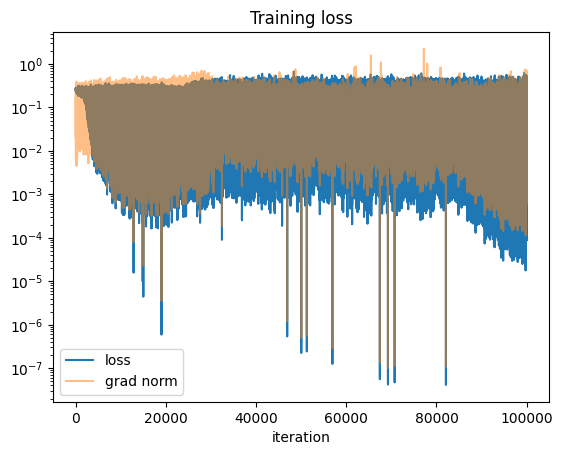

In [17]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)


Increasing the sequence length

In [18]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4):
    max_seq_len = 100
    seq_len = max_seq_len
    if learning_curriculum:
        seq_len = 10
    patience = patience_max
    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)
        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 20 # increase the sequence length
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            patience = patience_max
        if i % 500 == 0:
            print(i, ret)
    losses_df = pd.DataFrame(losses)
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')

    Xp,Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

0 {'loss': 0.30493706464767456, 'grad_norm': 0.18126817047595978}
500 {'loss': 0.205227792263031, 'grad_norm': 0.04830726981163025}
1000 {'loss': 0.25863224267959595, 'grad_norm': 0.0360579676926136}
1500 {'loss': 0.23010887205600739, 'grad_norm': 0.05130104348063469}
2000 {'loss': 0.1789846271276474, 'grad_norm': 0.01982135884463787}
2500 {'loss': 0.19447462260723114, 'grad_norm': 0.043901026248931885}
3000 {'loss': 0.23475010693073273, 'grad_norm': 0.09023164212703705}
3500 {'loss': 0.1327008306980133, 'grad_norm': 0.012913310900330544}
4000 {'loss': 0.03591196611523628, 'grad_norm': 0.080526202917099}
4500 {'loss': 0.22133581340312958, 'grad_norm': 0.020599691197276115}
5000 {'loss': 0.22440893948078156, 'grad_norm': 0.04433638975024223}
5500 {'loss': 0.05637267976999283, 'grad_norm': 0.1215956062078476}
6000 {'loss': 0.06844598799943924, 'grad_norm': 0.04761160910129547}
6500 {'loss': 0.21411927044391632, 'grad_norm': 0.04942672327160835}
7000 {'loss': 0.21375344693660736, 'grad_no

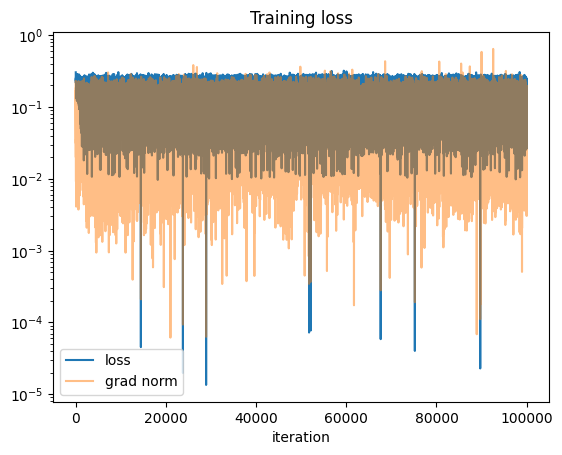

In [19]:
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

## LSTM

In [20]:
class LSTMCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.in_to_gates = nn.Linear(in_dim, hidden_dim * 4, bias=True)
        self.hidden_to_gates = nn.Linear(hidden_dim, hidden_dim * 4, bias=False)


    def forward(self, input, hidden):
        hx, cx = hidden
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)

        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        #
        # TODO TASK 3ingate = torch.sigmoid(ingate)
        #
        # Implement the LSTM equations
        #
        #my task
         # Apply sigmoid activation to the input, forget, and output gates
        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        # Apply tanh activation to the cell gate
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        # Calculate the new cell state. It is a combination of the old cell state (cx) modulated by the forget gate
        # and the new candidate values (cellgate) modulated by the input gate
        cy = (forgetgate * cx) + (ingate * cellgate)
        # Calculate the new hidden state (hy). It is the output gate modulating the tanh of the cell state
        hy = outgate * torch.tanh(cy)

        return hy, cy

0 {'loss': 0.25577056407928467, 'grad_norm': 0.02134794555604458}
500 {'loss': 0.23935498297214508, 'grad_norm': 0.02289954014122486}
1000 {'loss': 0.0010495868045836687, 'grad_norm': 0.0018474876414984465}
1500 {'loss': 0.00035189493792131543, 'grad_norm': 0.0006003460730426013}
2000 {'loss': 0.00021912006195634604, 'grad_norm': 0.0003151722776237875}
2009 Increasing seq length to:  30
2500 {'loss': 0.0001335903798462823, 'grad_norm': 0.00019475299632176757}
2586 Increasing seq length to:  50
2678 Increasing seq length to:  70
2754 Increasing seq length to:  90
        X:  [1. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
predicted:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
   target:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]


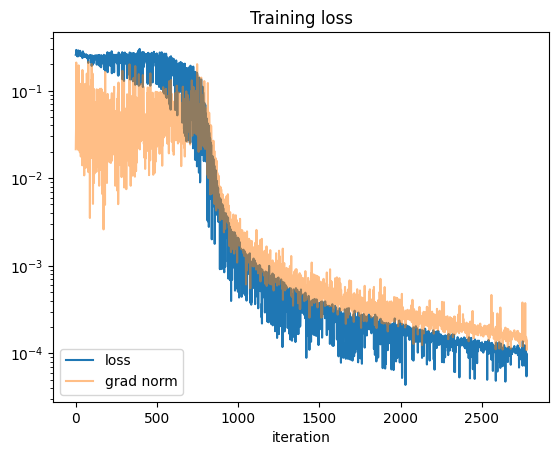

In [21]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
train_and_eval_parity(parity_trainer, learning_curriculum=True)

# Problem 2. GPT

Now we will implement the GPT architecture. GPT stands for _Generative Pre-trained Transformer_. GPT is a model trained to generate sequences, one token (character, word, or else) at a time, pretty similar to the RNN from slide 25 in our lecture. GPT is the architecture behind the immensely famous [ChatGPT](https://chat.openai.com/) and many other state-of-the-art AIs.

GPT training examples look like this (image taken from [GPT-3 Illustrated](https://jalammar.github.io/how-gpt3-works-visualizations-animations/)):

![image.png](attachment:image.png)

So, in the example above, the input sequence would be `Second law of robotics: A robot must obey the orders given it by human`, and the target sequence would be `law of robotics: A robot must obey the orders given it by human beings`. In short words, GPT is a transformer trained to do next-token prediction. This is termed _auto-regressive modeling_.

Aside of the main transformer elements we saw in the lecture there are two extra things we need to take care of to implement GPT. First, a definition:

**Embedding**: a real valued vector of dimension $d$ (usually high-dimensional) representing something. E.g. neural nets can process numbers, but not words, so in order to get them to process text we assign an embedding to each word.

Now, two extra elements we need to implement:

1. **Positional encoding**:
    
    Notice how none of the operations in the transformer cares about the position of the elements in the sequence. The only operation by which elements of the sequence interact with each other is self-attention, but self-attention is just a weighted average of the sequence elements. In a weighted average if you change the order of the elements the result is still the same.
    
    Sequences however have an order. For instance, if we switch `robot` and `human` in the example above, yielding as input `Second law of robotics: A human must obey the orders given it by robot beings`, the meaning of the sentence has totally changed, but the output of the transformer would be the same as with the original!
    
    To fix this we need to somehow inject information about the position. The way we do it is by adding to each embedding representing an input word another embedding to represent the position of such word. Consider $E$ a function that assigns embeddings to words, and $P$ a function that assigns embeddings to positions. Then, in our example, the input to the transformer would be:
    
    $$
    E(Second) + P(0), E(law) + P(1), E(of) + P(2), \dots, E(human) + P(14)
    $$
    
    The simplest way to implement positional encoding is using learned embeddings: we assume that we will process sequences of at most $T$ elements, and initialize randomly $T$ positional embeddings. During training, the model learns to modify our randomly initialize embeddings to better represent position. There are however many [methods for positional encodings](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/). This is actually a fairly active research area. Currently, the most popular (advanced) positional encoding method is [RoPE](https://blog.eleuther.ai/rotary-embeddings/).



2. **Causal self-attention**:

    In self-attention, each embedding attends to itself and all of the other elements in the sequence. Therefore each token gets to see all of the other tokens in the sequence. This is a problem in GPT, where the task is next-token prediction. If a token gets to see all of the other tokens in the sequence, including the next token, then it can trivially solve the task by just copying the value of the next token to the output!
    
    We need to modify attention so that each token is only allowed to attend to itself and the previous tokens in the sequence:
    
    ![image-2.png](attachment:image-2.png)
    
    We do so by applying a mask to the attention matrix:
    
    ![image-3.png](attachment:image-3.png)
    
    ![image-4.png](attachment:image-4.png)
    
    ![image-5.png](attachment:image-5.png)
    

So, in summary, in GPT:

1. We convert each input token in the sequence to an embedding and add to it a positional embedding.
2. We pass the encoded inputs through $N$ transformer blocks, which are just as the ones we described in class, except that we use causal self-attention instead of vanilla self-attention.
3. We use the output of the last transformer block as the input to a Softmax classifier that predicts the next-token in the sequence.

In the tasks below you will implement and use the GPT architecture.


**Tasks**:
1. **(3.5 pt)** Implement a transformer decoder block:

    1.1 **(2 pt)** Implement the forward pass of `MultiheadAttention`. You should implement the projection of the input embeddings to queries, keys and values (using `c_attn`), the computation of the causal attention matrix, and the output projection (using `c_proj`).
    
    _Note_: notice that we intend to do the query, key, and value projections in a single batched operation, therefore the `3 * n_embd` as output in `c_attn`. This is a more efficient implementation than doing separate linear projections for query, key, and value. However, you can use separate projection matrices if it is easier for you.
    
    _Note_: for the causal attention matrix you can use [masked_fill](https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html#torch.Tensor.masked_fill_) in order to apply the mask.
    
    1.2. **(0.5 pt)** Implement the forward pass of the attention block in `Block`. Use the following transformer block as guide of the operations you should implement:
    
    <div>
        <img src="attachment:image-6.png" width="200"/>
    </div>     
    
    Where `Norm` corresponds to layer normalization, i.e. `ln_1` and `ln_2` in our implementation.
    
    1.3. **(1 pt)** Implement the forward pass of the transformer in `GPT`. In here you should implement the operations that apply the token embedding `wte` and position embedding `wpe` to the inputs, as well as the stack of transformer blocks `h`.

2. **(7.0 pt max)** Train a GPT to learn to generate Harry Potter text based on the first four books:

    2.1 **(0.5 pt)** As we mentioned, neural nets need to assign vectors to words/characters in order to process them. Normally for that we use the [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module, as in the `__init__` method from `GPT`. It assigns vectors to integer numbers, which themselves can correspond to discrete symbols, like our characters or words. For this exercise you have to encode our text as integer numbers (we call this process tokenization). We will start with the simplest tokenization: encode each character as an integer. You will need to create two dictionaries: `stoi` (string to integer) and `itos` (integer to string) that map text to integers and integers to text, respectively.
    
    2.2 **(0.5 pt)** Define the targets `y` in the `get_batch` function so that the model does next token prediction.
    
    2.3 **(4.5 pt max)** Implement the code to generate data in the function `generate` of `GPT`. Here you just need to feed back the predicted next tokens that the model outputs as input for the next time step (**0.5 pt**). You can also implement [top-k sampling](https://huggingface.co/blog/how-to-generate) for an extra **1 pt**, and/or [Key-Value caching](https://huggingface.co/blog/optimize-llm) to accelerate inference for extra **3 pt**.
    
    2.4 **(1.5 pt)** Improve the tokenization.
    
    Using character tokenization is a simple first approach, but is rarely used in practice because it results in too long sequences (remember that the computational complexity of transformers grows quadratically with the sequence length). As an alternative we could split the text by whitespaces (e.g. the sentence _"said Dumbledore, smiling"_ becomes `["said", "Dumbledore,", "smiling"]`), and then encode each unique word in the text as an integer. This is termed word tokenization, and although it solves our issue with length, it comes with its own problems. For instance, how do we deal with a word that was not in the training set? We could assign an special token for unknown words, but there is a better alternative: subword tokenization.
    
    Subword tokenization divides words into smaller, meaningful units, from which other words can be formed. Consider the word "_chatGPT_", and imagine you are using a word-level tokenizer that doesn't recognize the term because it's not present in its vocabulary. In such a case, the entire term will be treated as an out-of-vocabulary (OOV) word, and the model may struggle to understand or generate meaningful predictions for it. A subword tokenizer, instead of treating the entire term as a single token, it would would break it down into smaller, more meaningful subword units. For instance, it might tokenize "_chatGPT_" into `chat` and `GPT`. This would enable the model to leverage its already acquired knowledge of `chat` and `GPT` to infer that likely "_chatGPT_" is a `GPT` with which you can `chat`.
    
    Implement subword tokenization. You can use [SentencePiece](https://github.com/google/sentencepiece) or any other subword tokenizer of your chosing. Repeat training. Do you see any improvement?.

3. **(2.5 pt máx)** Evaluate the English skills of your Harry Potter GPT.
    
    If you have successfully trained your GPT, you should have now a neural network that generates (vaguely) Harry Potter related text. How good of an English it learned from it? In this task we will assess it by calculating how well our model can tell apart proper and wrong English. We will test it in two problems:
    
    * Spelling test: we will present our model with pairs of `[word, non-word]`, e.g. `[observation, odservation]`. We will check on average how often our model assigns higher probablity to the properlly spelled word.
    * Grammar test: we will present our model with pairs of `[sentence, non-sentence]`, e.g. `[Hermione is listening to herself, Hermione is listening to itself]`. We will check on average how often our model assigns higher probablity to the properlly spelled sentence.
    
    In this exercise your task is to implement the function that will calculate the score of the model (**2 pt**). Remember from the lecture that we define the probability of a sentence of length $T$ composed of tokens $x_1, x_2, \dots, x_T$ as:
    
    $$
    p(x_1, x_2, \dots, x_T) = p(x_1)p(x_2 | x_1)p(x_3 | x_1, x_2) \dots p(x_T | x_1, x_2, \dots, x_{T-1})
    $$
    
   , and that our model's inputs and outputs look like this:
   
   <div>
        <img src="attachment:image.png" width="500"/>
    </div>
    
    _Hint: think of the equation for the cross entropy loss with which our model is trained, it should give you an easy answer_.
    
    For extra **0.5 pt**, and if you did task 2.4, check if a model trained on subwords does better on the grammar test.

In [22]:
class MultiheadAttention(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension bust be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim

        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        #
        # TODO TASK 1.1
        #
        # Implement the forward pass of MultiheadAttention
        #-----------------------------------@@@----------------------------------
        # Compute the attention scores
        att = torch.matmul(q, k.transpose(-2, -1)) # (B, nh, T, T)
        # Create a mask for the triangular part of the matrix (to handle sequences of variable length)
        mask = torch.tril(torch.ones((T, T), device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, T, T)
        # Apply the mask to the attention scores
        masked_att = att.masked_fill(mask == 0, float('-inf')) # (B, nh, T, T)
        # Apply softmax to the masked attention scores
        scores = torch.softmax(masked_att, dim=-1)
        # Apply dropout for regularization
        scores = self.attn_dropout(scores)


        # Compute attention output
        y = torch.matmul(scores, v) # (B, nh, T, hs) hs = C / nh
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y

### code to test MultiheadAttention

In [23]:

n_embd = 64
n_head = 8
block_size = 128
dropout = 0.1
multihead = MultiheadAttention(n_embd, n_head, block_size, dropout)
B,T =2 , 10
x = torch.randn(B,T,n_embd)
y = multihead(x)
print(f'expected output shape: {B,T,n_embd}')
print(f'actual output shape: {y.shape}')

expected output shape: (2, 10, 64)
actual output shape: torch.Size([2, 10, 64])


In [24]:
class MLP(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [25]:
class Block(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        #
        # TODO TASK 1.2
        #
        # Implement the forward pass of the attention block
        #
        # Apply the first layer normalization
        x_norm = self.ln_1(x)
        # Compute the attention output
        x_attn = self.attn(x_norm)
        # Add a residual connection (skip connection)
        x = x + x_attn # residual
        # Apply the second layer normalization
        x_norm = self.ln_2(x)
        # Pass the output through the MLP
        x_mlp = self.mlp(x_norm)
        x = x + x_mlp # # Add another residual connection
        return x

In [26]:
class GPT(nn.Module):

    def __init__(self, n_layer, n_embd, n_head, block_size, vocab_size, dropout):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(vocab_size, n_embd),
            wpe = nn.Embedding(block_size, n_embd),
            drop = nn.Dropout(dropout),
            h = nn.ModuleList([Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)]),
            ln_f = nn.LayerNorm(n_embd),
        ))
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        #
        # TODO TASK 1.3 (done)
        #
        # Implement the forward pass of the transformer
        #
        # my task 1.3--------------------------------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@@@
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos = torch.arange(t, device=device) # position ids of shape (t,)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb) # combine token and position embeddings
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        #---------------------------------------------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@@
        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            #loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1).squeeze())
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                #
                # TODO TASK 2.3  (done)
                #
                # Implement top k sampling
                #
                # my task 2.3--------------------------------------------------------------------------------@@@@@@@@@@@@@@@@
                # Implement top-k sampling
                values , indices = torch.topk(logits, top_k)
                logits = torch.full_like(logits, float('-inf')) # fill with -inf
                logits.scatter_(1, indices, values) # get top-k logits
                #---------------------------------------------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@@
                pass # ?
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat([idx, idx_next], dim=1) #  -------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@

        return idx

In [27]:
n_layer = 4     # Number of transformer blocks
n_embd = 64     # Embedding dimension
n_head = 8      # Number of attention heads
block_size = 128 # Maximum sequence length the model can handle
vocab_size = 1000 # Size of the vocabulary
dropout = 0.1   # Dropout rate

gpt_model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)

B, T = 2, 10  # Batch size and sequence length for test
idx = torch.randint(0, vocab_size, (B, T))

logits, loss = gpt_model(idx)
print('expected logits shape: ', (B, 1, vocab_size))
print("Logits shape:", logits.shape)

expected logits shape:  (2, 1, 1000)
Logits shape: torch.Size([2, 1, 1000])


Because there is no target labels, the `loss` will be `None`. Then logits only computed for the last token.

First we load our data containing the first four Harry Potter books:

In [29]:
data = ""
for i in range(4):
    input_file_path = f"hp{i + 1}.txt"
    with open(input_file_path, 'r', encoding='latin-1') as f:
        book = f.read()
    data += book + "\n"
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 2,652,656


Here the first few lines of the text:

In [30]:
print(data[:500])

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,
because they just didn't hold with such nonsense.

Mr. Dursley was the director of a firm called Grunnings, which made
drills. He was a big, beefy man with hardly any neck, although he did
have a very large mustache


We compute the vocabulary size, i.e. the number of unique tokens in our data. We are working at the character level, so we will count the number of unique characters:

In [31]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 	
 !"$%&'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ\]^_`abcdefghijklmnopqrstuvwxyz}~ü
vocab size: 91


Here you will integer encode the data. Define the two `dict` `stoi` and `itos` as described in the task 2.1. Afterwards we will split our data into train (first 90% of tokens) and validation (last 10% of tokens) sets

In [32]:
# TODO TASK 2.1
#
# create a mapping from characters to integers (stoi) and from integers to characters (itos)
#
# my task 2.1 ------------------------- -------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@
stoi ={char: i for i, char in enumerate(chars)}# Create mappings {char: i for i, char in enumerate(chars)} creates a dictionary (stoi) mapping characters to their indices. (this gives indices )
itos = {i: char for i, char in enumerate(chars)} # Create mappings {i: char for i, char in enumerate(chars)} creates a dictionary (itos) mapping indices to their corresponding characters.(this gives characters)
#---------------------------------------------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@@
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
train_data = np.array(train_ids, dtype=np.uint16)
val_data = np.array(val_ids, dtype=np.uint16)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

train has 2,387,390 tokens
val has 265,266 tokens


Here we define some variables regarding training and the model. You can play with them, however it all should work with these default values:

In [33]:
CUDA = True
device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
block_size = 256
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
# adamw optimizer
learning_rate = 1e-3 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 1e-4
# logging
eval_interval = 100
eval_iters = 10
log_interval = 10
# generation
max_new_tokens = 100
temperature = 0.8
top_k = None

We define the function that will sample training batches. Here you should define `y` so that the model is trained for next-token prediction:

In [34]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    # TODO TASK 2.2
    #
    # Define the targets that would implement next-token prediction
    #
    #my task 2.2 ------------------------- -------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix]) # Constructs target sequences by shifting the input sequences by one position. This is for next-token prediction.
    #---------------------------------------------------------------------------------------------@@@@@@@@@@@@@@@@@@@@@@@
    # transfer to GPU (non_blocking=True for faster operations)
    """ Construct target sequences for training. The targets are shifted by one position
     compared to the inputs, which is the standard approach for next-token prediction
     This means each target sequence is a shifted version of its corresponding input sequence"""
    if device == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        # If not using CUDA, simply transfer the data to the device
        x, y = x.to(device), y.to(device)
    # Return the batch of input sequences (x) and their corresponding target sequences (y)
    return x, y

This function implements a learning rate schedule with a [warm-up phase and a cosine learning rate decay](https://residentmario.github.io/pytorch-training-performance-guide/lr-sched-and-optim.html#cosine-annealed-warm-restart). This turns out to be necessary to train transformer models.

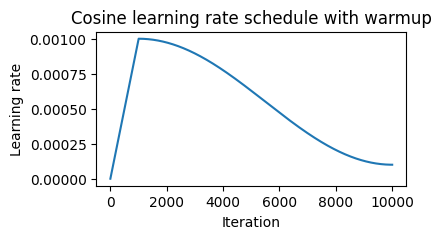

In [35]:
# learning rate decay scheduler (cosine with warmup)
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2) if it > lr_decay_iters, return min learning rate
    if it > lr_decay_iters:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (learning_rate - min_lr)

lr_seq = [get_lr(i) for i in range(max_iters)]
plt.figure(figsize=(4, 2))
plt.plot(lr_seq)
plt.title('Cosine learning rate schedule with warmup')
plt.xlabel('Iteration')
plt.ylabel('Learning rate')
plt.show()

For more details you can read [this post](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/#Why_are_these_tricks_required).

Here we define our model, optimizer, and run our training:

In [36]:
# We define the model
model = GPT(n_layer, n_embd, n_head, block_size, vocab_size, dropout)
model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# training loop
X, Y = get_batch('train') # fetch the very first batch
t0 = time.time()
iter_num = 0 # number of iterations in the lifetime of this process
while True:
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    # evaluate the loss on train/val sets
    if iter_num % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        start = " "
        start_ids = encode(start)
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        model.eval()
        try:
            with torch.no_grad():
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        except Exception as e:
            pass # If you haven't implemented the generate code
        model.train()
        print('-' * 100)
        print("Example generated:")
        print('-' * 100)
        print(decode(y[0].tolist()))
        print('-' * 100)
    logits, loss = model(X, Y)
    X, Y = get_batch('train')
    # clip the gradient
    if grad_clip != 0.0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % log_interval == 0:
        lossf = loss.item() # loss as float. note: this is a CPU-GPU sync point
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms")
    iter_num += 1
    # termination conditions
    if iter_num > max_iters:
        break

step 0: train loss 4.5117, val loss 4.5117
----------------------------------------------------------------------------------------------------
Example generated:
----------------------------------------------------------------------------------------------------
 pNvmQL}E 6mseüBOlB7"	.dldI1 ny8bsHl!_ $KCL6e`tsHXQm*qHV:~?aL)pjbSXJvj"y`rH1\)r)i15\z`f/39a)63b?O$!m
----------------------------------------------------------------------------------------------------
iter 0: loss 4.5115, time 3985.91ms
iter 10: loss 4.5108, time 186.74ms
iter 20: loss 4.5078, time 187.85ms
iter 30: loss 4.5019, time 187.54ms
iter 40: loss 4.4892, time 185.47ms
iter 50: loss 4.4707, time 186.55ms
iter 60: loss 4.4551, time 187.50ms
iter 70: loss 4.4389, time 188.34ms
iter 80: loss 4.4185, time 188.64ms
iter 90: loss 4.3937, time 187.94ms
step 100: train loss 4.3586, val loss 4.3534
----------------------------------------------------------------------------------------------------
Example generated:
--------

Now we will assess the English knowledge of our trained model (Task 3). We load the pairs of words and sentences and print some examples:

In [37]:
with open("wuggy.txt", 'r') as f:
    spelling_samples = [sample[:-1].split(',') for sample in f]
with open("blimp.txt", 'r') as f:
    grammar_test_samples = [sample[:-1].split(',') for sample in f]
print(spelling_samples[0])
print(grammar_test_samples[0])

['objectivity', 'osbrectifity']
["Harry hadn't attacked himself", "Harry hadn't attacked herself"]


In [38]:
from tqdm.notebook import tqdm
def get_sample_prob(X):
    #
    # TODO TASK 3
    #
    # Compute the probability of sequence X
    #
    logits, _ = model(X[:, :-1]) # Forward pass through the model. Exclude the last token for prediction purposes
    log_probs = F.log_softmax(logits, dim=-1) # Compute the log probabilities of the tokens

    targets = X[:, 1:]  # The targets are the tokens shifted by one position

    gathered_log_probs = torch.gather(log_probs, 2, targets.unsqueeze(1)).squeeze(2)
    # print(gathered_log_probs.shape)
    # Sum the log probabilities for the entire sequence
    sequence_log_prob = gathered_log_probs.sum()

    return sequence_log_prob # Convert back from log probabilities
# Evaluate spelling correctness using the model
spelling_scores = []
for sample in tqdm(spelling_samples):
    word, non_word = sample
    # Tokenize and prepare the word and non-word for the model
    tokenized_word = encode(word)
    tokenized_word = torch.tensor(tokenized_word, dtype=torch.long).unsqueeze(0)
    prob_word = get_sample_prob(tokenized_word.to(device))
    tokenized_non_word = encode(non_word)
    tokenized_non_word = torch.tensor(tokenized_non_word, dtype=torch.long).unsqueeze(0)
    prob_non_word = get_sample_prob(tokenized_non_word.to(device))
    # Compare the probabilities and score for spelling correctness
    spelling_score = 1.0 * (prob_word > prob_non_word)
    spelling_scores.append(spelling_score)
# Calculate and print the average spelling score
print("Spelling score: ", torch.stack(spelling_scores).mean().item())

grammar_scores = []
for sample in tqdm(grammar_test_samples):
    sentence, non_sentence = sample
    tokenized_sentence = encode(sentence) # # Tokenize and prepare the sentence and non-sentence for the model
    tokenized_sentence = torch.tensor(tokenized_sentence, dtype=torch.long).unsqueeze(0)
    prob_sentence = get_sample_prob(tokenized_sentence.to(device))
    tokenized_non_sentence = encode(non_sentence)
    tokenized_non_sentence = torch.tensor(tokenized_non_sentence, dtype=torch.long).unsqueeze(0)
    prob_non_sentence = get_sample_prob(tokenized_non_sentence.to(device))
    # # Compare the probabilities and score for grammar correctness
    grammar_scores.append(1.0 * (prob_sentence > prob_non_sentence))
# Calculate and print the average grammar score
print("Grammar score: ", torch.stack(grammar_scores).mean().item())

  0%|          | 0/40000 [00:00<?, ?it/s]

Spelling score:  0.5112999677658081


  0%|          | 0/500 [00:00<?, ?it/s]

Grammar score:  0.5160000324249268


# Problem 3. Vision transformer

Transformers go well beyond text. They have been applied with tremendous success to many modalities (audio, images, video, graphs, etc). However, its application to images can be unintuitive, as we do not tend to think of them as the 1D sequences for which transformers were designed. In this exercise we will implement a vision transformer to illustrate how this works.

We use the classic MNIST dataset and will try to get a vision transformer to do classification of handwritten numbers.

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

100%|██████████| 9912422/9912422 [00:00<00:00, 167415825.38it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40204345.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36251940.25it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4700352.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Let's take a look at one of the samples:

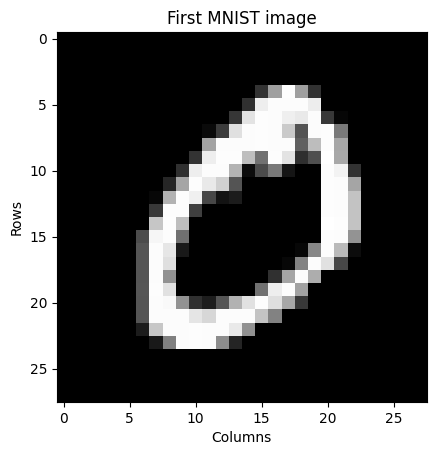

In [ ]:
first_image = np.array(mnist_trainset[1][0])
plt.imshow(first_image, cmap='gray')
plt.title('First MNIST image')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

The way we turn an image into a 1D sequence is pretty straightforward. We can simply flatten it in a row major form. That is, we will turn our 28x28 pixels image into a 784 long sequence, with the first row becoming the first 24 elements, the second row the next, and so on.

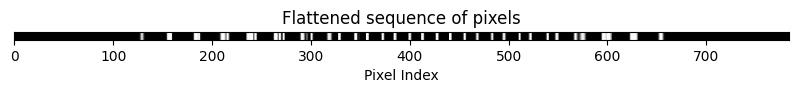

In [ ]:
flattened_image = first_image.reshape(-1)
plt.figure(figsize=(10, 0.1))
plt.imshow([flattened_image], cmap='gray', aspect='auto')
plt.title('Flattened sequence of pixels')
plt.xlabel('Pixel Index')
plt.yticks([])
plt.show()

This should work fine, but there is a technical issue. Remember that transformer's computational cost scales quadratically with the length of the sequence. Notice that our tiny 24x24 pixels image already results in a sequence of length 784. This is ok as long as you have a moderately large GPU and you use a not too large batch size, but in Colab, or in the smallest GPUs in our cluster we might already run into memory issues. Moreover, in most practical applications we will be dealing with much larger images. For a standard HD image of 1024 x 768 pixels we would have a sequence length of 786432! This is already almost 10 times more than what the state-of-the-art models like GPT-4 support.

In practice, instead of working on sequences of pixels, we use sequences of image patches. We will split our image into non-overlapping 4x4 patches:

Text(0.5, 1.0, 'Image with 4x4 Patches')

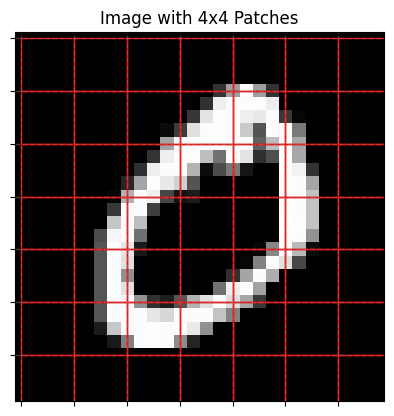

In [ ]:
image_size = first_image.shape[0]
patch_size = 4
fig, ax = plt.subplots()
ax.imshow(first_image, cmap='gray')
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        rect = Rectangle((j, i), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
ax.set_xticks(np.arange(0, image_size, patch_size))
ax.set_yticks(np.arange(0, image_size, patch_size))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(True, which='both', linestyle='--', linewidth=1, color='gray', alpha=0.5)
plt.title(f'Image with {patch_size}x{patch_size} Patches')

When we flattened it, it becomes a sequence of 49 patches:

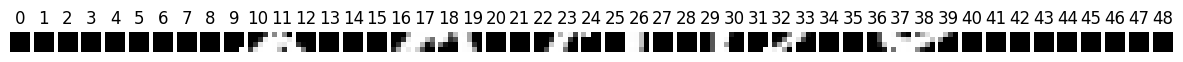

In [ ]:
patch_sequence = []
for i in range(0, image_size, patch_size):
    for j in range(0, image_size, patch_size):
        patch = first_image[i:i+patch_size, j:j+patch_size]
        patch_sequence.append(patch)
num_patches = (image_size // patch_size) ** 2
fig, axs = plt.subplots(1, num_patches, figsize=(15, 2))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch, cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')

plt.show()

_Note: in most practical applications we will be dealing with much larger images, so we will need larger patches in order to sufficiently shorten the sequence length._


Finally we transform each patch, a 4x4 matrix, into a vector of 16 elements, which is the input our transformer expects. We simply flatten each patch:

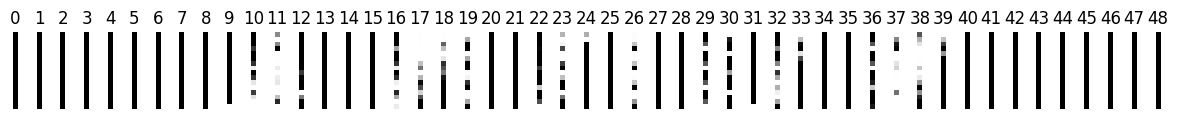

In [ ]:
fig, axs = plt.subplots(1, num_patches, figsize=(15, 1))
for i, patch in enumerate(patch_sequence):
    axs[i].imshow(patch.reshape(-1, 1), cmap='gray')
    axs[i].set_title(i)
    axs[i].axis('off')
plt.show()

We have our inputs ready. Now onto the model. This is the architecture our digit classifier will use:
    
  <div>
        <img src="attachment:image.png" width="500"/>
    </div>

**Tasks**:
1. **(3 pt)** Implement the architecture of the classifier in the class `VisionTransformer` and train it on the MNIST dataset. Note that you can reuse most of the elements that you already implemented for `GPT`. You just need to avoid auto-regressive masking and figure out how to input the patches instead of discrete tokens.
2. **(2 pt)** Implement a simple convolutional network classifier and compare its performnace with the vision transformer.
3. **(4 pt máx)** Implement any of the two methods from the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/pdf/2112.13492v1.pdf) to try to improve the performance of our model. You can find a Keras tutorial implementing them [here](https://keras.io/examples/vision/vit_small_ds/#implement-locality-self-attention). Each method is worth **2 pt**.

Let's start defining some parameters. As before, it works with these defaults, but you can play with them

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

device = "cuda" if CUDA else "cpu"
# data
batch_size = 32
patch_size = 4
img_w, img_h = np.array(mnist_trainset[1][0]).shape
block_size = img_w // patch_size * img_h // patch_size
# model
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2
input_size = patch_size * patch_size
n_classes = 10 # 10-digit classification
# adamw optimizer
learning_rate = 5e-4 # max learning rate
max_iters = 10000 # total number of training iterations
grad_clip = 1.0 # clip gradients at this value, or disable if == 0.0
# learning rate decay settings
warmup_iters = 1000 # how many steps to warm up for
lr_decay_iters = max_iters
min_lr = 5e-5
# logging
eval_interval = 1000
log_interval = 100

Now we preprocess our dataset to transform every image into patch sequences of shape `(49, patch_size, patch_size)`

In [ ]:
# Transformation to extract patches and flatten them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)),
    transforms.Lambda(lambda x: x.contiguous().view(-1, patch_size, patch_size)),
])

# Apply the transform to the loaded datasets
mnist_trainset.transform = transform
mnist_testset.transform = transform

Here you have to define the model:

In [ ]:
class MultiheadAttention(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        assert n_embd % n_head == 0, "The embedding dimension bust be divisible by the number of heads"
        self.n_head = n_head
        self.n_embd = n_embd
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2) # ?
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # print(f'q: {q.shape}')
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # print(f'k: {k.shape}')
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # print(f'v: {v.shape}')
        #
        # TODO TASK 1.1
        #
        # Implement the forward pass of MultiheadAttention
        #
        att = torch.matmul(q, k.transpose(-2, -1)) # (B, nh, T, T)
        mask = torch.tril(torch.ones((T, T), device=x.device)).unsqueeze(0).unsqueeze(0) # (1, 1, T, T)
        masked_att = att.masked_fill(mask == 0, float('-inf')) # (B, nh, T, T)
        scores = torch.softmax(masked_att, dim=-1) # ?
        scores = self.attn_dropout(scores)


        # Compute attention output
        y = torch.matmul(scores, v) # (B, nh, T, hs) hs = C / nh
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        y = self.resid_dropout(y)
        return y





class MLP(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
class Block(nn.Module):

    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = MultiheadAttention(n_embd, n_head, block_size, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x):
        #
        # TODO TASK 1.2
        #
        # Implement the forward pass of the attention block
        #
        x_norm = self.ln_1(x)
        x_attn = self.attn(x_norm)
        x = x + x_attn # residual
        x_norm = self.ln_2(x)
        x_mlp = self.mlp(x_norm)
        x = x + x_mlp # residual
        return x

In [ ]:
class VisionTransformer(torch.nn.Module):
    def __init__(self, input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout):
        super().__init__()
        #
        # TODO TASK 1
        #
        # Define the architecture of the vision transformer as illustrated in the pic above
        #
        patch_size= int(input_size ** 0.5)
        n_patches = block_size
        self.patch_size = patch_size
        self.pos_embedding = nn.Parameter(torch.zeros(1, n_patches+1, n_embd))
        self.patch_to_embedding = nn.Linear(patch_size * patch_size, n_embd)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, n_embd))
        self.dropout = nn.Dropout(dropout)

        self.block_size = block_size
        self.transformer = nn.ModuleList([
            Block(n_embd, n_head, n_patches + 1, dropout) for _ in range(n_layer)
        ]) # ?
        self.to_cls_token = nn.Identity()
        # self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(n_embd, n_classes),
            # nn.Softmax(dim=1)
        )
        self.block_size = block_size
        self.transformer = None # ?
        self.classifier = None # ?
        # init all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.LayerNorm):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, x, targets=None):
        device = x.device
        b, t = x.size(0), x.size(1)
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        #
        # TODO TASK 1
        #
        # Define the forward pass of the vision transformer
        #
        x = self.patch_to_embedding(x)
        x = x.view(b, t, -1)

        cls_tokens = self.cls_token.expand(b, -1, -1).to(device)
        x = torch.cat((cls_tokens, x), dim=1)  # [batch_size, num_patches+1, n_embd]

        x += self.pos_embedding.to(device)
        x = self.dropout(x)

        for block in self.transformer:
            x = block(x)

        x = x[:, 1:, :].mean(dim=1)



        logits = self.classifier(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

In [ ]:
# Create data loaders
train_loader = DataLoader(dataset=mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=mnist_testset, batch_size=batch_size, shuffle=False)

# Model
model = VisionTransformer(input_size, n_classes, n_layer, n_embd, n_head, block_size, dropout)
model.to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

iter_counter = 0
while iter_counter < max_iters:
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flatten the patch
        patch_sequence = data.view(-1, block_size, patch_size * patch_size).to(device)
        target = target.to(device)
        # Forward pass
        logits, loss = model(patch_sequence, target)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Calculate accuracy
        _, predicted = torch.max(logits, -1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        total_loss += loss.item()
        iter_counter += 1
        # Log loss and accuracy
        if iter_counter % log_interval == 0:
            avg_loss = total_loss / log_interval
            accuracy = correct / total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Loss: {avg_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
            total_loss = 0.0
            correct = 0
            total = 0
        # Evaluate test loss
        if iter_counter % eval_interval == 0 or iter_counter == max_iters:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data, test_target in test_loader:
                    test_patch_sequence = test_data.view(-1, block_size, patch_size * patch_size).to(device)
                    test_target = test_target.to(device)
                    test_outputs, loss = model(test_patch_sequence, test_target)
                    test_loss += loss.item()
                    _, test_predicted = torch.max(test_outputs, -1)
                    test_total += test_target.size(0)
                    test_correct += (test_predicted == test_target).sum().item()
            avg_test_loss = test_loss / len(test_loader)
            test_accuracy = test_correct / test_total
            print(f'Iter [{iter_counter}/{max_iters}], Batch [{batch_idx+1}/{len(train_loader)}], '
                  f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
            model.train()
        if iter_counter == max_iters:
            break

TypeError: ignored